In [1]:
# pip install scipy  # Run this if scipy isn't installed!

In [17]:
pip install --upgrade numpy

Defaulting to user installation because normal site-packages is not writeable
ERROR: Will not install to the user site because it will lack sys.path precedence to numpy in /local/environments/a345/a345-venv/lib/python3.9/site-packages
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import Button, Slider

from scipy.fft import fft, ifft, fftshift, fftfreq
from scipy.interpolate import interp1d
import scipy.signal
from scipy import integrate
from scipy.signal.windows import blackman

In [2]:
import matplotlib
%matplotlib ipympl

# Instructions! ✨

1. Make sure to run the first three cells. If you don't run '%matplotlib ipympl' you will not be able to interact with the figures. 
2. If you want the figures to fit your screen better, you can adjust it by clicking and sliding the bottom right corner of the figure. To see a different view of a 3-D plot, just drag the plot with your mouse.
3. To change given variables in the plot, just move the sliders on the figure.
4. You do not and will not need to know how the code works! You may look at it for your own interest. 

# What is a Fourier Transform?

## Descriptively:

When looking at a signal, one can think of that signal as a combination of simpler sinusoidal signals. The general application of a fourier transform is to break up that combined signal into smaller parts.

This first plot will show you a signal that is composed of a <font color=#D92C07>sum of three sine waves</font>, and its fourier transform. It is of the form: $$\require{color}
\definecolor{circle}{RGB}{217,86,16} f(x) = A_1\cdot \sin(2 \pi  {\color{circle}a}(x-p))+A_2 \cdot \sin(2 \pi {\color{circle}b}(x-p))+A_3 \cdot \sin(2 \pi {\color{circle}c}(x-p)) $$ Where $A_1, A_2, A_3$ are the amplitudes of each sine wave, and ${\color{circle}a, b, c}$ are the wavenumbers of each sine wave. You are able to change ${\color{circle}a, b,}$ and ${\color{circle}c}$ with the sliders. Run the next cell to interact with it. 

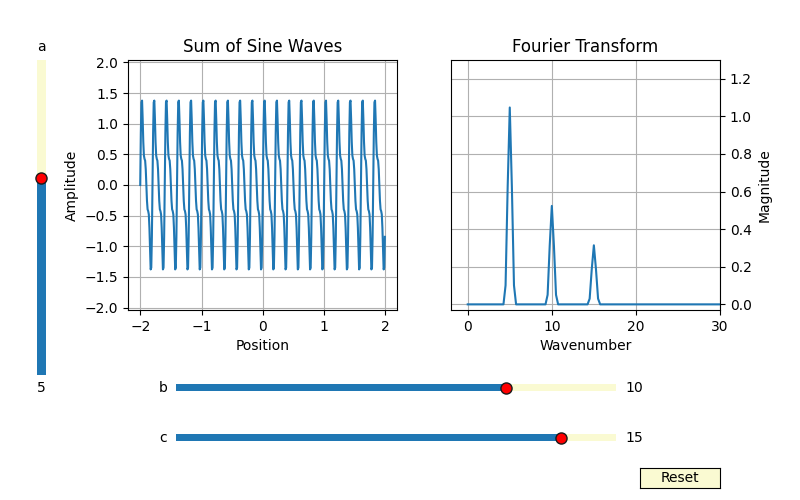

In [3]:
# A function that is a sum of sine waves 
def sum_of_sines(x, phase, frequencies, amplitudes):
    return sum(a * np.sin(2 * np.pi * f * (x - np.full(x.shape, p))) 
               for f, a, p in zip(frequencies, amplitudes, phase))

# Set up the time array
x = np.arange(-2, 2, 0.01)
N = len(x)
a = 5.
b = 10.
c = 15.

# Define frequencies and amplitudes (try changing these! See what it does to the plot!)
phase = [0, 0, 1]
frequencies = [a, b, c]
amplitudes = [1, 0.5, 0.3]

# Calculate the function values
y = sum_of_sines(x, phase, frequencies, amplitudes)

# Calculate the Fourier transform
w = blackman(N)
fft_y = fft(y*w)
fft_freq = fftfreq(N, x[1] - x[0])

# Plot the original function
fig, (ax, ax2) = plt.subplots(1, 2,figsize=(8, 5))  # plt.subplots(1 row, 2 columns)
line, = ax.plot(x, y)
line2, = ax2.plot(fft_freq[:len(fft_freq)//2], 5/N * np.abs(fft_y)[:len(fft_freq)//2])

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.16, bottom=0.38)
axcolor = 'lightgoldenrodyellow'

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.04, 0.25, 0.0225, 0.63])  # [left, bottom, width, height]
a_slider = Slider(
    ax=axamp,
    label="a",
    valmin=-20,
    valmax=20,
    valinit=a,
    orientation="vertical",
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Make a horizontally oriented slider to control the centre
axcentre = fig.add_axes([0.22, 0.21, 0.55, 0.03])   
b_slider = Slider(
    ax=axcentre,
    label="b",
    valmin=-20,
    valmax=20,
    valinit=b,
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Make a horizontal slider to control the width.
axwidth = fig.add_axes([0.22, 0.11, 0.55, 0.03])
c_slider = Slider(
    ax=axwidth,
    label='c',
    valmin=-20,
    valmax=20,
    valinit=c,
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)


# The function to be called anytime a slider's value changes
def update(val): 
    newval = sum_of_sines(x, phase, [a_slider.val, b_slider.val, c_slider.val], amplitudes)
    line.set_ydata(newval)
    fft_y = np.fft.fft(w * newval)
    line2.set_ydata(5/N * np.abs(fft_y)[:len(fft_freq)//2])
    fig.canvas.draw_idle()


# register the update function with each slider
c_slider.on_changed(update)
b_slider.on_changed(update)
a_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    c_slider.reset()
    b_slider.reset()
    a_slider.reset()
button.on_clicked(reset)

ax.set_xlabel('Position')
ax.set_ylabel('Amplitude')
ax.set_title('Sum of Sine Waves')
ax.grid(True)
ax.axis('equal')

# # Plot the Fourier transform
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xlabel('Wavenumber')
ax2.set_ylabel('Magnitude')
ax2.set_title('Fourier Transform')
ax2.set_xlim([-2, 30])
ax2.set_ylim([-0.03,1.3])
ax2.grid(True)
plt.show()


#### <font color=#6991D2>There is a _Fourier Transform_ relationship between the distribution of apertures, $A(x)$, and the power pattern, $P(\theta)$</font> (IOR1 Lecture Notes Part 03, slide 47). But what does that mean? 


### Mathematical Definition:

The _Fourier Transform_ of <font color=#b59a02>a function, $f(x)$</font>, is denoted as $\require{color} \definecolor{gold}{RGB}{181, 154, 2} \definecolor{blue}{RGB}{122,163,207} \mathcal{F}[{\color{gold}f(x)}]({\color{blue}k})$. Think of this as a new function, $\mathcal{F}({\color{blue}k})$, specified for the function ${\color{gold}f(x)}$, which is why it is in square brackets. It is generally written as $\mathcal{F}[{\color{gold}f}]({\color{blue}k})$. Mathematically, it is defined as: $$ \mathcal{F}[{\color{gold}f}]({\color{blue}k}) := \int_{-\infty}^{\infty} {\color{gold}f(x)}\; e^{-2\pi i {\color{blue}k} {\color{gold}x}} \; d{\color{gold}x} \qquad \forall {\color{blue}k} \in \mathbb{R}$$ 

###### (_To be mathematically rigorous, we must have that the function ${\color{gold}f(x)}$ is piece-wise continuous, absolutely integrable, and defined on $\mathbb{R}$._)

An integral? An exponential? What's going on here? Let's take it apart.

Let's start with $e^{-2\pi i {\color{blue}k} {\color{gold}x}}$. This component of the integral represents a clockwise spinning with respect to ${\color{gold}x}$ in the complex plane. That is, if we plot $g({\color{gold}x})= e^{-2\pi i {\color{blue}k} {\color{gold}x}}$ (parametric in ${\color{gold}x}$) in the complex plane (x-axis as the real axis, y-axis as imaginary), it traces out the unit circle. Let's look at it in the next cell. 

In this cell you will be able to <font color=#b59a02>change the values of the amplitude</font>, which is multiplied to the exponential. The other value you will be able to change is  <font color=#b59a02>the ending value of the array of x-values</font>. This should depict the path the x-values trace up to that value. 

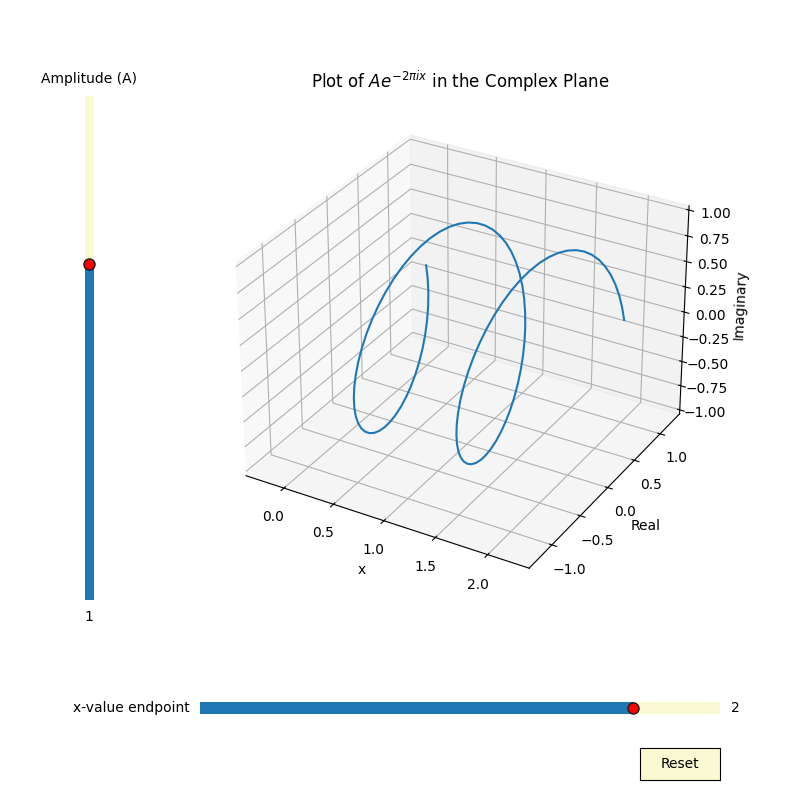

In [4]:
# Define the complex exponential function
def y(xval,A): return A*np.exp(-2 * np.pi * 1j * xval)

# Define the variables
x = 2  # x values range from 0 to x = 2 initially
A = 1    # inital amplitude
N = 100
xval = np.linspace(0, x, N)  # Domain
yval = y(xval,A)             # Range

# Create the figure
fig = plt.figure(figsize=(8, 8))
# Create a 3D plot and plot the complex exponential function
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot(xval, np.real(yval), np.imag(yval))

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Define color for slider track 
axcolor = 'lightgoldenrodyellow'

# Make a horizontal slider to control the x-values.
ax_x = plt.axes([0.25, 0.1, 0.65, 0.03])
x_slider = Slider(
    ax=ax_x,
    label='x-value endpoint',
    valmin=-3,
    valmax=3,
    valinit=x,
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Make a vertically oriented slider to control the amplitude
ax_A = plt.axes([0.1, 0.25, 0.0225, 0.63])
A_slider = Slider(
    ax=ax_A,
    label=r"Amplitude (A)",
    valmin=-3,
    valmax=3,
    valinit=A,
    orientation="vertical",
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Define the function that updates plot values anytime a slider's value changes
def update(val):
    global xval
    xval = np.linspace(0, x_slider.val, N)
    yval = y(xval, A_slider.val)
    line.set_data(xval, np.real(yval))     # set x- and y-values
    line.set_3d_properties(np.imag(yval))  # set z-values
    fig.canvas.draw_idle()

# register the update function with each slider
x_slider.on_changed(update)
A_slider.on_changed(update)

# Create a Reset button to reset the sliders to initial values
def reset(event):
    x_slider.reset()
    A_slider.reset()

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
button.on_clicked(reset)

# Plot formatting
ax.set_title(r'Plot of $Ae^{-2\pi i x}$ in the Complex Plane')
ax.set_xlabel('x')
ax.set_ylabel('Real')
ax.set_zlabel('Imaginary')
ax.set_xlim([-3,3])
ax.set_ylim([-2.5,2.5])
ax.set_zlim([-2.5,2.5])
ax.grid(True)
ax.axis('equal')

plt.show()

Notice that if you click and drag on the plot, you can see the plot at different angles. <font color=#6991D2>Try looking at the three 2D angles (Real vs Imaginary, $x$ vs Real, $x$ vs Imaginary)</font>. 

Now. you'll notice that if we let ${\color{gold}f(x)}$ be a spatial function, then ${\color{gold}x}$ clearly has the units of length. In order for proper dimensions to be satisfied, $e^{-2\pi i {\color{blue}k} {\color{gold}x}}$ needs to be dimensionless (you don't want units of $e^{\text{[length]}}$), that is, ${\color{blue}k}$ must have units of $\text{length}^{-1}$ (<font color=#6991D2>a wavenumber!</font>). We will call ${\color{blue}k}$ the _<font color=#6991D2>wavenumber</font>_ from now onwards.

##### (Say you had a time series, $g(t)$, instead of $f(x)$. Then your '$k$' in this case would be the _frequency_ (1/time), and we'd probably denote it as $\nu$ instead of $k$.)

Now, multiplying by the original function, we have ${\color{gold}f(x)} e^{-2\pi i {\color{blue}k} {\color{gold}x}}$ (the integrand of the fourier transform). This changes the radius/amplitude of our circle to ${\color{gold}f(x)}$. It works the same as $A$ in the previous cell. So, as ${\color{gold}f(x)}$ varies up and down, the plot varies up and down as it spins.

Let's take ${\color{gold}f(x)} = \sin(2 \pi \alpha {\color{gold}x})$. You can see how this behaves in the next figure:

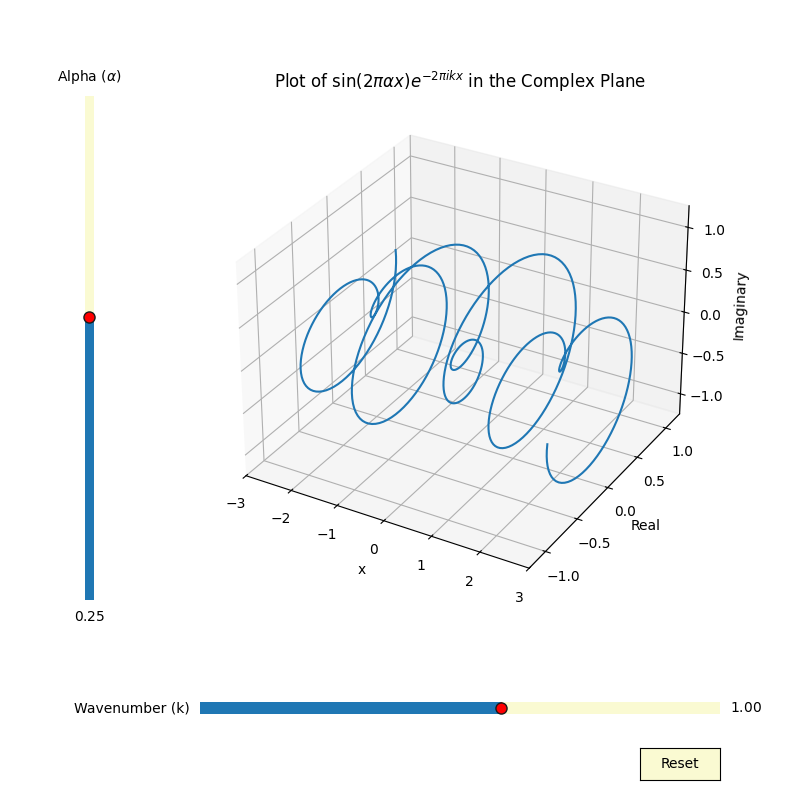

In [5]:
# Define functions for the product of functions inside the integral
def y(xval,alpha, k): return np.sin(2 * np.pi *alpha*xval)*np.exp(-2 * np.pi * k * 1j * xval)

# Define the initial variables
N = 500
alpha = 0.25  # initial alpha value
k = 1   # initial wavenumber
xval = np.linspace(-3, 3, N)  # x values range from -3 to 3 initially; Domain
yval = y(xval, alpha, k)      # Range

# Create the figure
fig = plt.figure(figsize=(8, 8))
# Create a 3D plot and plot the complex exponential function
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot(xval, np.real(yval), np.imag(yval))

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Define color for slider track 
axcolor = 'lightgoldenrodyellow'

# Make a horizontal slider to control the wavenumber.
ax_k = plt.axes([0.25, 0.1, 0.65, 0.03])
k_slider = Slider(
    ax=ax_k,
    label='Wavenumber (k)',
    valmin=-2*np.pi,
    valmax=2*np.pi,
    valinit=k,
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Make a vertically oriented slider to change alpha
ax_a = plt.axes([0.1, 0.25, 0.0225, 0.63])
a_slider = Slider(
    ax=ax_a,
    label=r"Alpha ($\alpha$)",
    valmin=-2,
    valmax=2,
    valinit=alpha,
    orientation="vertical",
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Define the function that updates plot values anytime a slider's value changes
def update(val):
    yval = y(xval, a_slider.val, k_slider.val)
    line.set_data(xval, np.real(yval))     # set x- and y-values
    line.set_3d_properties(np.imag(yval))  # set z-values
    fig.canvas.draw_idle()

# register the update function with each slider
k_slider.on_changed(update)
a_slider.on_changed(update)

# Create a Reset button to reset the sliders to initial values
def reset(event):
    k_slider.reset()
    a_slider.reset()

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
button.on_clicked(reset)

# Plot formatting
ax.set_xlabel('x')
ax.set_xlim([-3,3])
ax.set_ylabel('Real')
ax.set_ylim([-1.25,1.25])
ax.set_zlabel('Imaginary')
ax.set_zlim([-1.25,1.25])
ax.set_title(r'Plot of $\sin (2\pi\alpha x) e^{-2\pi i k x}$ in the Complex Plane')
ax.grid(True)
plt.show()

Again, <font color=#6991D2>remember to look at different angles of the plot</font>! What do you notice about the relationship between $k$ and $\alpha$?

### Integrating

Now that we've visualised the _integrand_, we can look at what happens when you integrate over all values of x. In other words, what is the area under the curve with respect to $x$?

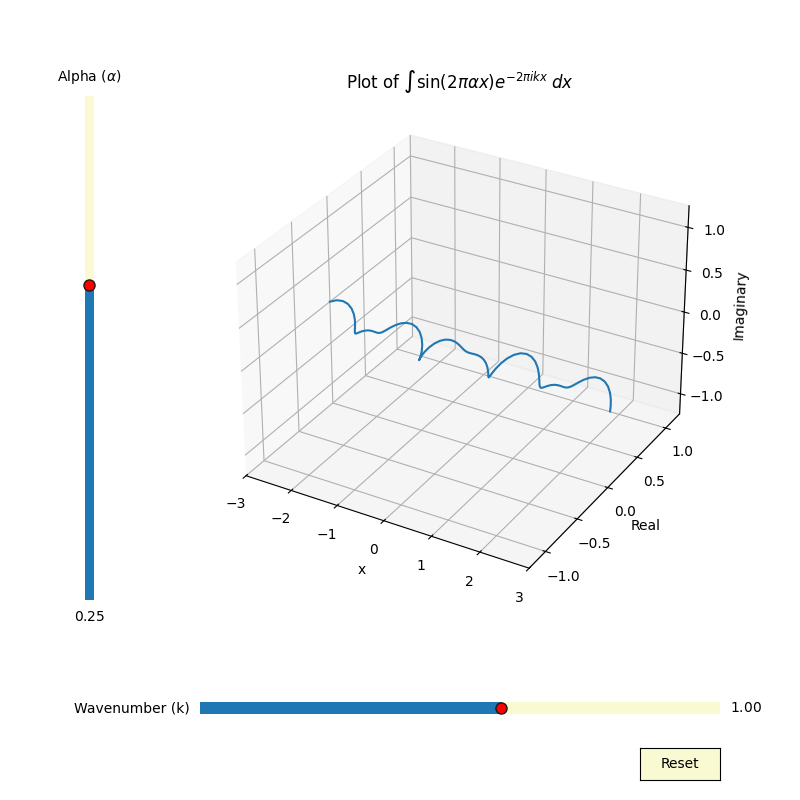

In [9]:
# Integrate the complex function

# Define integrand function
def y(xval, alpha, k): return np.sin(2*np.pi*alpha*xval)*np.exp(-2 * np.pi * k * 1j * xval)

# Define the initial variables
N = 100
alpha = 0.25                     # initial alpha value
k = 1                           # initial wavenumber
x = np.linspace(-3, 3, N)       # endpoints of integral 

data = []   # initialise array to store integral values

# take the integral for small increments from 0 to i
for n in x:
    xval = np.linspace(-3, n, N)                     # limits of integration: -3 and n (from x). Number of steps between 0 and i: N. 
    yval = y(xval, alpha, k)                         # Calculate integrand
    integral_r = np.trapz(np.real(yval), xval)   # Real part of the integral
    integral_i = np.trapz(np.imag(yval), xval)   # Imaginary part of the integral
    data.append([integral_r, integral_i])            # append to data array

# Convert lists to numpy arrays
data = np.array(data)

# Create the figure
fig = plt.figure(figsize=(8, 8))
# Create a 3D plot and plot the complex exponential function
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot(xval, data[:,0], data[:,1])

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Define color for slider track 
axcolor = 'lightgoldenrodyellow'

# Make a horizontal slider to control the wavenumber.
ax_k = plt.axes([0.25, 0.1, 0.65, 0.03])
k_slider = Slider(
    ax=ax_k,
    label='Wavenumber (k)',
    valmin=-2*np.pi,
    valmax=2*np.pi,
    valinit=k,
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Make a vertically oriented slider to change alpha
ax_a = plt.axes([0.1, 0.25, 0.0225, 0.63])
a_slider = Slider(
    ax=ax_a,
    label=r"Alpha ($\alpha$)",
    valmin=-1,
    valmax=1,
    valinit=alpha,
    orientation="vertical",
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Define the function that updates plot values anytime a slider's value changes
def update(val):
    # recalculate integral
    data = []  # re-initialise array to store integral values
    for n in x:
        xval = np.linspace(-3, n, N)                    
        yval = y(xval, a_slider.val, k_slider.val)       
        integral_r = np.trapz(np.real(yval), xval)  
        integral_i = np.trapz(np.imag(yval), xval)   
        data.append([integral_r, integral_i])            
    data = np.array(data)
    
    line.set_data(xval, data[:,0])     # set x- and y-values
    line.set_3d_properties(data[:,1])  # set z-values
    # Redraw the figure
    fig.canvas.draw_idle()

# register the update function with each slider
k_slider.on_changed(update)
a_slider.on_changed(update)

# Create a Reset button to reset the sliders to initial values
def reset(event):
    k_slider.reset()
    a_slider.reset()

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
button.on_clicked(reset)

# Plot formatting
ax.set_xlabel('x')
ax.set_xlim([-3,3])
ax.set_ylabel('Real')
ax.set_ylim([-1.25,1.25])
ax.set_zlabel('Imaginary')
ax.set_zlim([-1.25,1.25])
ax.set_title(r'Plot of $\int \sin (2\pi\alpha x) e^{-2\pi ikx}\; dx$')
ax.grid(True)
plt.show()

Now, the fourier transform will be the function that computes this integral for all values of $k$ in the domain. 

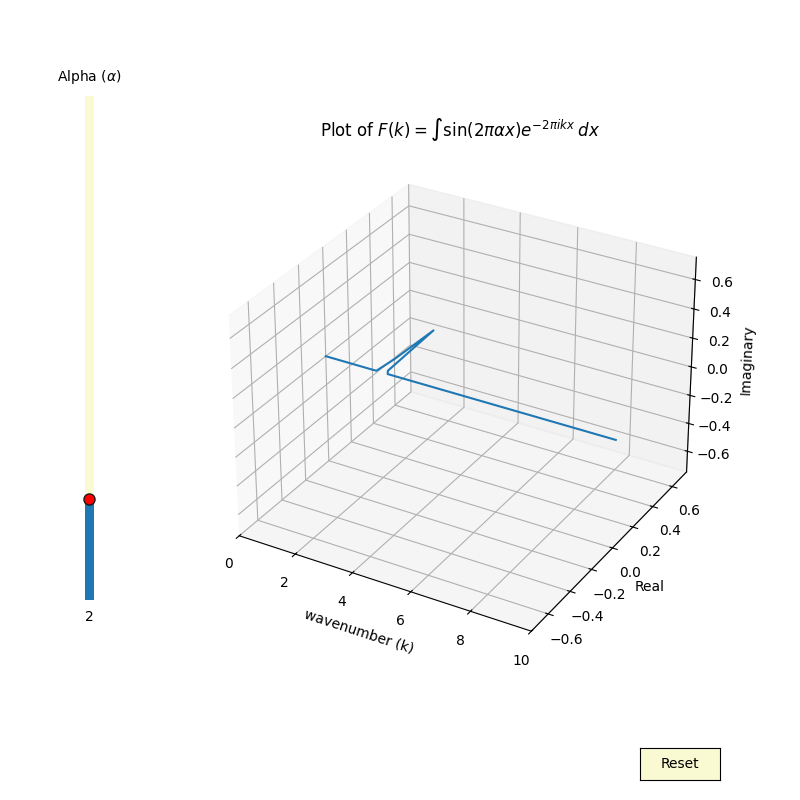

In [11]:
# Define fourier transform function
def fourier_transform(k, alpha):
    # For a sine wave sin(2*pi*alpha*x), the Fourier transform is:
    # F(k) = (i/2) * [delta(k-alpha) - delta(k+alpha)]
    # We approximate delta functions with narrow Gaussians
    sigma = 0.05  # Width of the Gaussian
    positive_freq = 1/2 * np.exp(-(k-alpha)**2 / (2*sigma**2))
    negative_freq = -1/2 * np.exp(-(k+alpha)**2 / (2*sigma**2))
    return positive_freq + negative_freq

# Define the initial variables
N = 100
alpha = 2               # initial alpha value
k = np.linspace(0, 10, N)

F_k_real = np.real(fourier_transform(k, alpha))
F_k_imag = np.imag(fourier_transform(k, alpha))

# Create the figure
fig = plt.figure(figsize=(8, 8))
# Create a 3D plot and plot the complex exponential function
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot(k, F_k_real, F_k_imag)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25)

# Define color for slider track 
axcolor = 'lightgoldenrodyellow'

# Make a vertically oriented slider to change alpha
ax_a = plt.axes([0.1, 0.25, 0.0225, 0.63])
a_slider = Slider(
    ax=ax_a,
    label=r"Alpha ($\alpha$)",
    valmin=0,
    valmax=10,
    valinit=alpha,
    orientation="vertical",
    track_color=axcolor,
    handle_style={'edgecolor':'0.1', 'facecolor':'r','size':'8'}
)

# Define the function that updates plot values anytime a slider's value changes
def update(val):
    # recalculate
    F_k_real = np.real(fourier_transform(k, a_slider.val))
    F_k_imag = np.imag(fourier_transform(k, a_slider.val))
    line.set_data(k, F_k_real)     # set x- and y-values
    line.set_3d_properties(F_k_imag)  # set z-values
    # Redraw the figure
    fig.canvas.draw_idle()

# register the update function with each slider
a_slider.on_changed(update)

# Create a Reset button to reset the sliders to initial values
def reset(event):
    a_slider.reset()

resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
button.on_clicked(reset)

# Plot formatting
ax.set_xlabel('wavenumber (k)')
ax.set_xlim([0,10])
ax.set_ylabel('Real')
ax.set_ylim([-0.75,0.75])
ax.set_zlabel('Imaginary')
ax.set_zlim([-0.75,0.75])
ax.set_title(r'Plot of $F(k) = \int \sin (2\pi\alpha x) e^{-2\pi ikx}\; dx$')
ax.grid(True)
plt.show()

What does this have to do with anything? Well, it is all about the _frequency, $k$_! If the frequency lines up.... 
#### (FINISH THIS TRAIN OF THOUGHT)

######  _Keep in mind, both $k$ and $t$ are variables._


<!-- ### Inverse (do we need this?)

$$ f(x) = \int_{-\infty}^{\infty} \mathcal{F}[f](k) \; e^{2\pi i k x} \; \underbrace{dk}_{!!} \qquad \forall x \in \mathbb{R} $$ We can see that 
$$
f(x) = \int_{-\infty}^{\infty}  \underbrace{\int_{-\infty}^{\infty} f(x)\; e^{-2\pi i k x}}_{\mathcal{F}[f](k) } \; e^{2\pi i k x} \; dx \; dk \qquad \forall k \in \mathbb{R},\; \forall x \in \mathbb{R}
$$

One can see this is true, since the exponentials cancel out. Therefore we have the inverse Fourier transform! We can recover the original function $f(x)$ from its Fourier transform.  -->


### More:

For a good conceptual demonstration, watch this video from 3Blue1Brown!
https://www.youtube.com/watch?v=spUNpyF58BY

In [25]:
plt.close('all')

# Apertures and Power patterns 

# Convolution

What is a convolution?

## The Convolution Theorem

## rejected material